1. 더미 데이터 불러오기

In [1]:
import pandas as pd

# 필요한 컬럼만 선택하여 CSV 읽기
selected_columns = [
    "시도명", "시군구명"
]

df = pd.read_csv("./data/소상공인시장진흥공단_상가(상권)정보_경남_202503.csv", 
                 usecols=selected_columns).fillna("")

# 시군구별 데이터 개수 집계
city_counts = df["시군구명"].value_counts().sort_values(ascending=False)
print("경남 시/군별 상가 데이터 개수:")
print(city_counts)

경남 시/군별 상가 데이터 개수:
시군구명
김해시          26565
진주시          19254
양산시          16324
창원시 성산구      13519
거제시          12317
창원시 의창구      11093
창원시 마산합포구     9869
창원시 진해구       8428
창원시 마산회원구     8283
통영시           7385
사천시           6405
밀양시           5737
거창군           3341
남해군           3212
창녕군           3156
함안군           2939
하동군           2856
고성군           2647
함양군           2123
산청군           1995
합천군           1946
의령군           1074
Name: count, dtype: int64


In [2]:
import pandas as pd

# 필요한 컬럼만 선택하여 CSV 읽기 (상위 100줄만)
selected_columns = [
    "상권업종대분류코드", "상권업종대분류명", "상권업종중분류코드", "상권업종중분류명", 
    "상권업종소분류코드", "상권업종소분류명", "시도코드", "시도명", "시군구코드", "시군구명", 
    "행정동코드", "행정동명", "법정동명", "지번주소", "도로명주소", "경도", "위도"
]

df = pd.read_csv("./data/소상공인시장진흥공단_상가(상권)정보_경남_202503.csv", 
                 usecols=selected_columns,
                 #nrows=10000
                 ).fillna("")

# 시군구명이 "남해군"인 데이터만 필터링
cityname = "김해시"
df = df[df["시군구명"] == cityname].reset_index(drop=True)

print(f"{cityname} 데이터 수: {len(df)}개")
print(f"\n{cityname} 내 시군구별 분포:")
print(df["시군구명"].value_counts())

# 텍스트 컬럼 생성 (주소 정보를 결합)
df["text"] = (df["시도명"].str.strip() + " " + 
              df["시군구명"].str.strip() + " " + 
              df["행정동명"].str.strip() + " " + 
              df["상권업종대분류명"].str.strip() + " " + 
              df["상권업종중분류명"].str.strip() + " " + 
              df["상권업종소분류명"].str.strip())

print(f"\n=== {cityname} 상가 데이터 샘플 ===")

print(df.head(2))

김해시 데이터 수: 26565개

김해시 내 시군구별 분포:
시군구명
김해시    26565
Name: count, dtype: int64

=== 김해시 상가 데이터 샘플 ===
  상권업종대분류코드 상권업종대분류명 상권업종중분류코드 상권업종중분류명 상권업종소분류코드   상권업종소분류명  시도코드   시도명  \
0        Q1     보건의료      Q102       의원    Q10201  내과/소아과 의원    48  경상남도   
1        N1  시설관리·임대      N104    고용 알선    N10401     고용 알선업    48  경상남도   

   시군구코드 시군구명     행정동코드  행정동명 법정동명                지번주소                  도로명주소  \
0  48250  김해시  48250630  장유3동  장유동  경상남도 김해시 장유동 875-3       경상남도 김해시 율하로 478   
1  48250  김해시  48250540   내외동   내동   경상남도 김해시 내동 160-7  경상남도 김해시 금관대로1313번길 6   

           경도         위도                               text  
0  128.826911  35.167199    경상남도 김해시 장유3동 보건의료 의원 내과/소아과 의원  
1  128.862397  35.241413  경상남도 김해시 내외동 시설관리·임대 고용 알선 고용 알선업  


2. 전처리(클렌징)

In [3]:
import re

def clean(txt: str) -> str:
    txt = re.sub(r"http\S+|www\S+", " ", txt)            # URL
    txt = re.sub(r"[^\w가-힣\s]", " ", txt)              # 특수문자
    txt = re.sub(r"\s+", " ", txt).strip()               # 중복 공백
    return txt.lower()

df["clean"] = df["text"].apply(clean)

3. SimCSE 임베딩

In [4]:
from sentence_transformers import SentenceTransformer
from tqdm import tqdm

MODEL_ID = "BM-K/KoSimCSE-roberta"      # unsupervised 버전
embedder = SentenceTransformer(MODEL_ID)

BATCH = 256
emb_list = []
for i in tqdm(range(0, len(df), BATCH)):
    batch = df["clean"].iloc[i : i + BATCH].tolist()
    embs  = embedder.encode(batch, batch_size=len(batch),
                            normalize_embeddings=True)
    emb_list.extend(embs)
import numpy as np
emb = np.vstack(emb_list).astype("float32")              # (N, 768)

No sentence-transformers model found with name BM-K/KoSimCSE-roberta. Creating a new one with mean pooling.
100%|██████████| 104/104 [00:31<00:00,  3.34it/s]


normalize_embeddings=True → 이미 L2 노멀라이즈된 벡터라 Inner Product = 코사인.

4. FAISS 인덱스 생성

In [5]:
import faiss

d = emb.shape[1]                     # 768
index = faiss.IndexFlatIP(d)         # 작은 데이터셋은 Flat IP로 충분
index.add(emb)                       # 전체 아이디어 삽입

5. 유사 아이디어 검색 함수

In [6]:
def find_similar(query: str, top_k: int = 5):
    q_emb = embedder.encode([clean(query)],
                            normalize_embeddings=True).astype("float32")
    D, I = index.search(q_emb, top_k)      # D: 코사인, I: 행 인덱스
    return list(zip(I[0], D[0]))           # [(idx, score), …]

def find_similar_with_details(query: str, top_k: int = 5):
    """검색 결과와 함께 상가 정보도 보여주는 함수"""
    results = find_similar(query, top_k)
    print(f"검색어: '{query}'")
    print(f"상위 {top_k}개 결과:")
    print("-" * 50)
    
    for i, (idx, score) in enumerate(results, 1):
        row = df.iloc[idx]
        print(f"{i}. 유사도: {score:.3f}")
        print(f"   상호명: {row.get('상호명', 'N/A')}")
        print(f"   업종: {row['상권업종대분류명']} > {row['상권업종중분류명']} > {row['상권업종소분류명']}")
        print(f"   위치: {row['시도명']} {row['시군구명']} {row['행정동명']}")
        print(f"   주소: {row['지번주소']}")
        print()

# 실제 상가 데이터에 맞는 검색어로 테스트
print("=== 실제 상가 데이터 검색 테스트 ===")
find_similar_with_details("진주시 꽃집")
print()
find_similar_with_details("김해시 의원")
print()
find_similar_with_details("경상남도 소매")

=== 실제 상가 데이터 검색 테스트 ===
검색어: '진주시 꽃집'
상위 5개 결과:
--------------------------------------------------
1. 유사도: 0.777
   상호명: N/A
   업종: 소매 > 식물 소매 > 꽃집
   위치: 경상남도 김해시 진영읍
   주소: 경상남도 김해시 진영읍 진영리 1602-2

2. 유사도: 0.777
   상호명: N/A
   업종: 소매 > 식물 소매 > 꽃집
   위치: 경상남도 김해시 진영읍
   주소: 경상남도 김해시 진영읍 여래리 700-26

3. 유사도: 0.777
   상호명: N/A
   업종: 소매 > 식물 소매 > 꽃집
   위치: 경상남도 김해시 진영읍
   주소: 경상남도 김해시 진영읍 진영리 1600-13

4. 유사도: 0.777
   상호명: N/A
   업종: 소매 > 식물 소매 > 꽃집
   위치: 경상남도 김해시 진영읍
   주소: 경상남도 김해시 진영읍 여래리 755

5. 유사도: 0.777
   상호명: N/A
   업종: 소매 > 식물 소매 > 꽃집
   위치: 경상남도 김해시 진영읍
   주소: 경상남도 김해시 진영읍 여래리 714-36


검색어: '김해시 의원'
상위 5개 결과:
--------------------------------------------------
1. 유사도: 0.686
   상호명: N/A
   업종: 보건의료 > 의원 > 기타 의원
   위치: 경상남도 김해시 진영읍
   주소: 경상남도 김해시 진영읍 진영리 1629-4

2. 유사도: 0.671
   상호명: N/A
   업종: 보건의료 > 의원 > 기타 의원
   위치: 경상남도 김해시 부원동
   주소: 경상남도 김해시 부원동 609-10

3. 유사도: 0.659
   상호명: N/A
   업종: 보건의료 > 의원 > 기타 의원
   위치: 경상남도 김해시 삼안동
   주소: 경상남도 김해시 삼방동 177-8

4. 유사도: 0.656
   상호명:

6. HDBSCAN 클러스터링

In [7]:
import hdbscan, joblib, numpy as np

n = len(df)                                     # 현재 데이터 크기
#min_cluster = max(2, int(0.2 * n))              # 20% 또는 최소 2
#min_samples = min(min_cluster, n - 1)

# 관대한 파라미터
min_cluster = 20    # 20개만 모여도 클러스터
min_samples = 10         # 10개 이웃만 있어도 핵심 포인트

clusterer = hdbscan.HDBSCAN(
        metric="euclidean",
        min_cluster_size=min_cluster,
        min_samples=min_samples,
        prediction_data=True
).fit(emb)

df["cluster"] = clusterer.labels_
print(df["cluster"].value_counts())
joblib.dump(clusterer, "hdbscan.pkl")

/Users/leeyoungho/miniforge3/envs/ai_3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/leeyoungho/miniforge3/envs/ai_3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


cluster
-1      3200
 217     250
 63      232
 21      228
 306     177
        ... 
 315      20
 314      20
 342      20
 173      20
 399      20
Name: count, Length: 451, dtype: int64


['hdbscan.pkl']

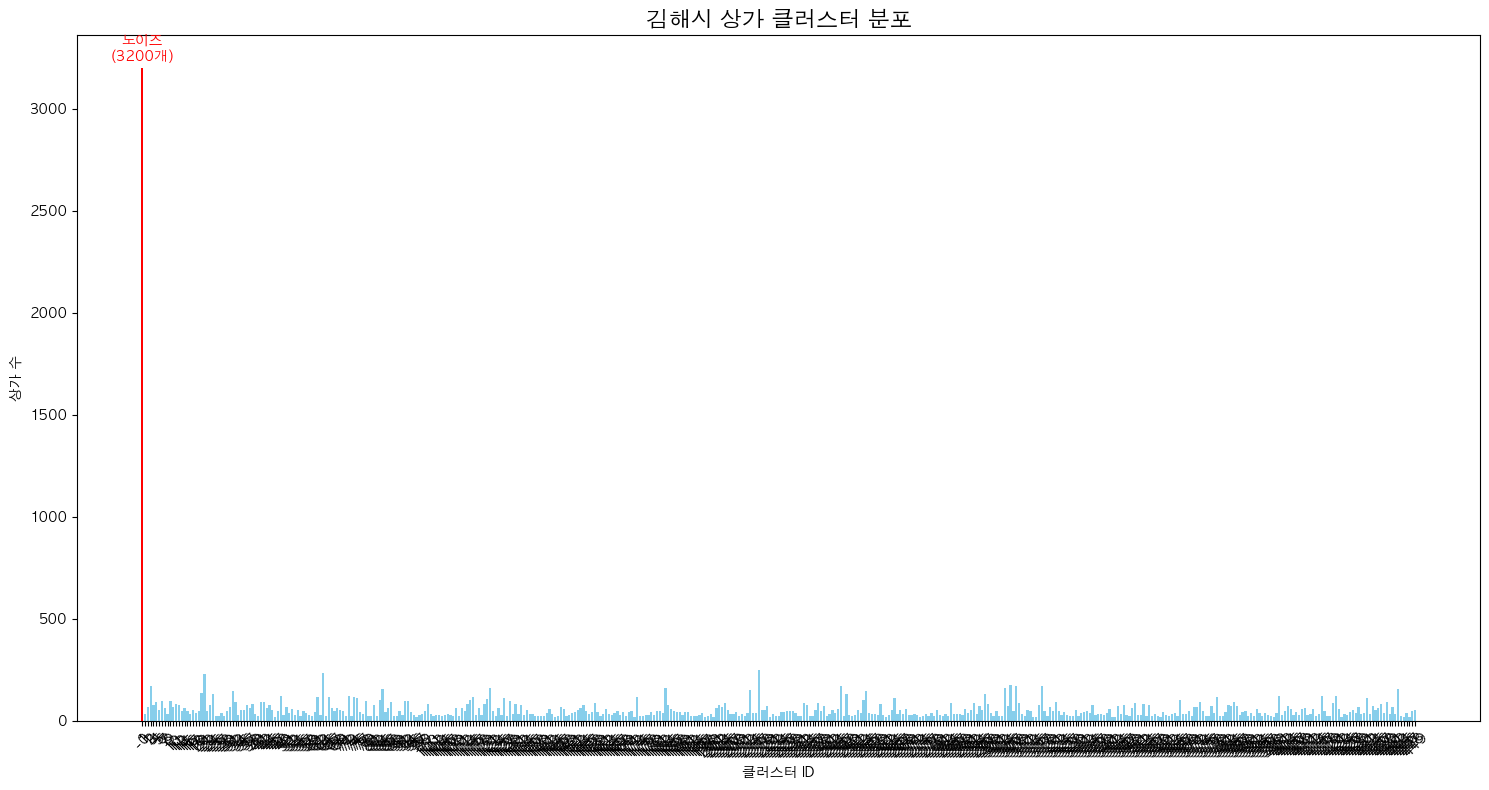

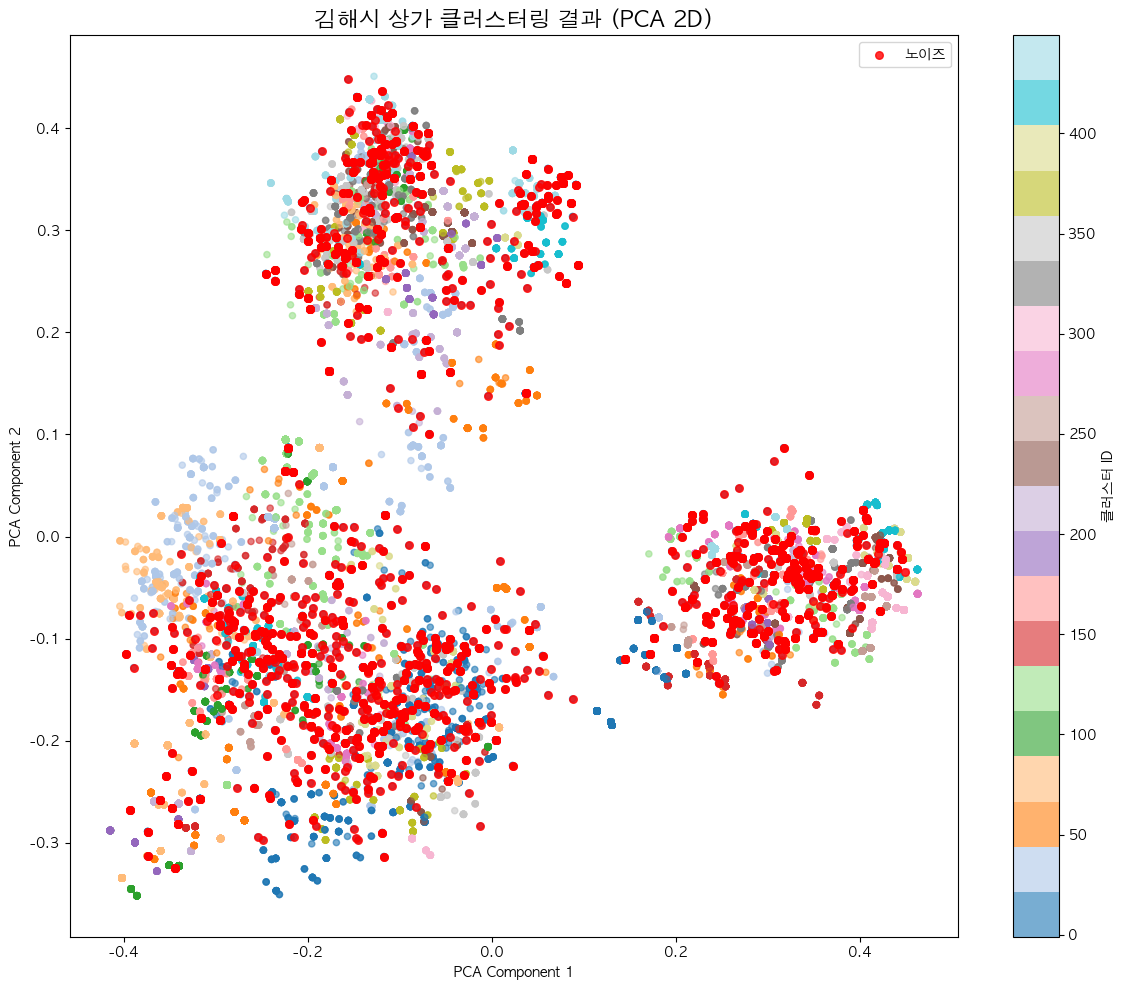

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

# 한글 폰트 설정
plt.rcParams['font.family'] = 'AppleGothic'  # macOS용
plt.rcParams['axes.unicode_minus'] = False

# 1. 클러스터 분포 막대 그래프
plt.figure(figsize=(15, 8))
cluster_counts = df['cluster'].value_counts().sort_index()
colors = ['red' if x == -1 else 'skyblue' for x in cluster_counts.index]

plt.bar(range(len(cluster_counts)), cluster_counts.values, color=colors)
plt.title(f'{cityname} 상가 클러스터 분포', fontsize=16, fontweight='bold')
plt.xlabel('클러스터 ID')
plt.ylabel('상가 수')
plt.xticks(range(len(cluster_counts)), cluster_counts.index, rotation=45)

# 노이즈 클러스터(-1) 강조
plt.text(0, cluster_counts.iloc[0] + 20, f'노이즈\n({cluster_counts.iloc[0]}개)', 
         ha='center', va='bottom', fontweight='bold', color='red')

plt.tight_layout()
plt.show()

# 2. PCA로 2D 시각화
pca = PCA(n_components=2)
emb_2d = pca.fit_transform(emb)

plt.figure(figsize=(12, 10))
scatter = plt.scatter(emb_2d[:, 0], emb_2d[:, 1], c=df['cluster'], 
                     cmap='tab20', alpha=0.6, s=20)

# 노이즈 포인트(-1)는 빨간색으로 강조
noise_mask = df['cluster'] == -1
plt.scatter(emb_2d[noise_mask, 0], emb_2d[noise_mask, 1], 
           c='red', alpha=0.8, s=30, label='노이즈')

plt.title(f'{cityname} 상가 클러스터링 결과 (PCA 2D)', fontsize=16, fontweight='bold')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.colorbar(scatter, label='클러스터 ID')
plt.tight_layout()
plt.show()

In [9]:
# 노이즈 상세 분석
cluster_13_data = df[df['cluster'] == -1]

print("=== 노이즈 상세 분석 ===")
print(f"총 상가 수: {len(cluster_13_data)}개")
print(f"전체 대비 비율: {len(cluster_13_data)/len(df)*100:.1f}%")

print("\n1. 업종별 분포:")
print(cluster_13_data['상권업종대분류명'].value_counts())
print("\n   중분류별 분포:")
print(cluster_13_data['상권업종중분류명'].value_counts().head(10))

print("\n2. 지역별 분포:")
print(cluster_13_data['행정동명'].value_counts())

print("\n3. 상세 업종별 분포 (상위 15개):")
print(cluster_13_data['상권업종소분류명'].value_counts().head(15))

print("\n4. 노이즈의 상가 샘플 (처음 10개):")
print("-" * 80)
for idx, row in cluster_13_data.head(10).iterrows():
    print(f"• {row['행정동명']} - {row['상권업종대분류명']} > {row['상권업종중분류명']} > {row['상권업종소분류명']}")
    print(f"  주소: {row['지번주소']}")
    print()

=== 노이즈 상세 분석 ===
총 상가 수: 3200개
전체 대비 비율: 12.0%

1. 업종별 분포:
상권업종대분류명
음식         987
소매         909
과학·기술      360
예술·스포츠     284
수리·개인      281
교육         202
시설관리·임대     94
부동산         40
숙박          39
보건의료         4
Name: count, dtype: int64

   중분류별 분포:
상권업종중분류명
한식             346
기타 간이          227
식료품 소매         205
기타 교육          153
스포츠 서비스        152
철물·건설자재 소매     147
섬유·의복·신발 소매    134
유원지·오락         118
주점             110
중식             102
Name: count, dtype: int64

2. 지역별 분포:
행정동명
삼안동      312
칠산서부동    271
진영읍      268
동상동      261
회현동      247
불암동      218
활천동      202
주촌면      187
장유3동     144
생림면      131
북부동      126
장유2동     125
한림면      118
부원동      110
내외동      107
장유1동     107
대동면      104
진례면       89
상동면       73
Name: count, dtype: int64

3. 상세 업종별 분포 (상위 15개):
상권업종소분류명
철물/공구 소매업     115
국수/칼국수         82
중국집            72
자동차 정비소        69
채소/과일 소매업      59
국/탕/찌개류        59
김밥/만두/분식       58
반찬/식료품 소매업     54
노래방            54
시각 디자인업        53
빵/도넛          

In [10]:
# 노이즈 줄이기 위한 HDBSCAN 파라미터 조정 (지원되는 메트릭만 사용)
import hdbscan, joblib, numpy as np

print("=== 노이즈 줄이기 실험 ===")

# 실험 1: 더 관대한 파라미터 (euclidean)
print("\n1. 더 관대한 파라미터로 재실험")
clusterer_1 = hdbscan.HDBSCAN(
    metric="euclidean",
    min_cluster_size=10,      # 20 → 10으로 줄임
    min_samples=5,            # 10 → 5로 줄임
    prediction_data=True,
    cluster_selection_epsilon=0.5,  # 0.3 → 0.5로 증가
    alpha=1.0
).fit(emb)

labels_1 = clusterer_1.labels_
noise_count_1 = len(labels_1[labels_1 == -1])
print(f"노이즈 수: {noise_count_1}개 ({noise_count_1/len(df)*100:.1f}%)")
print(f"클러스터 수: {len(set(labels_1)) - (1 if -1 in labels_1 else 0)}개")

# 실험 2: 가장 관대한 파라미터
print("\n2. 가장 관대한 파라미터로 재실험")
clusterer_2 = hdbscan.HDBSCAN(
    metric="euclidean",
    min_cluster_size=5,       # 최소 클러스터 크기를 5로
    min_samples=3,            # 최소 샘플 수를 3으로
    prediction_data=True,
    cluster_selection_epsilon=0.6,  # 임계값을 0.6으로
    alpha=1.0
).fit(emb)

labels_2 = clusterer_2.labels_
noise_count_2 = len(labels_2[labels_2 == -1])
print(f"노이즈 수: {noise_count_2}개 ({noise_count_2/len(df)*100:.1f}%)")
print(f"클러스터 수: {len(set(labels_2)) - (1 if -1 in labels_2 else 0)}개")

=== 노이즈 줄이기 실험 ===

1. 더 관대한 파라미터로 재실험


/Users/leeyoungho/miniforge3/envs/ai_3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/leeyoungho/miniforge3/envs/ai_3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


노이즈 수: 16개 (0.1%)
클러스터 수: 33개

2. 가장 관대한 파라미터로 재실험


/Users/leeyoungho/miniforge3/envs/ai_3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/leeyoungho/miniforge3/envs/ai_3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


노이즈 수: 0개 (0.0%)
클러스터 수: 7개


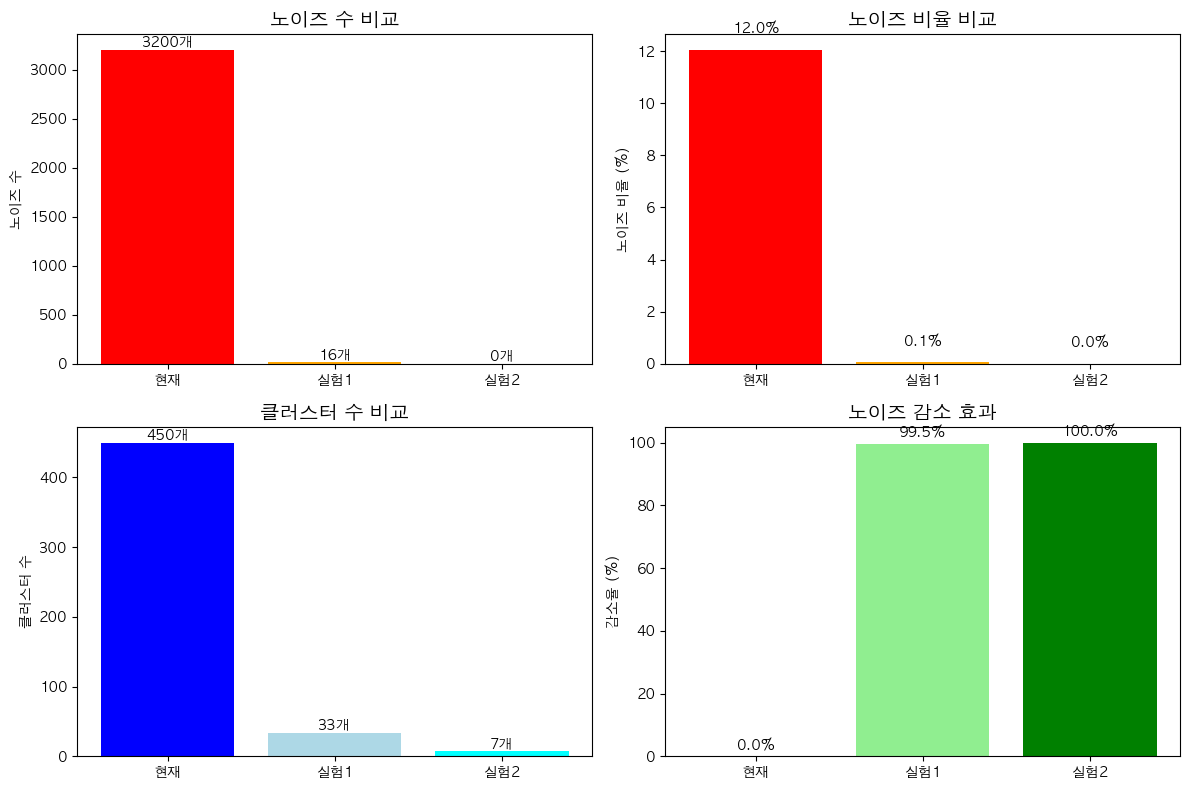

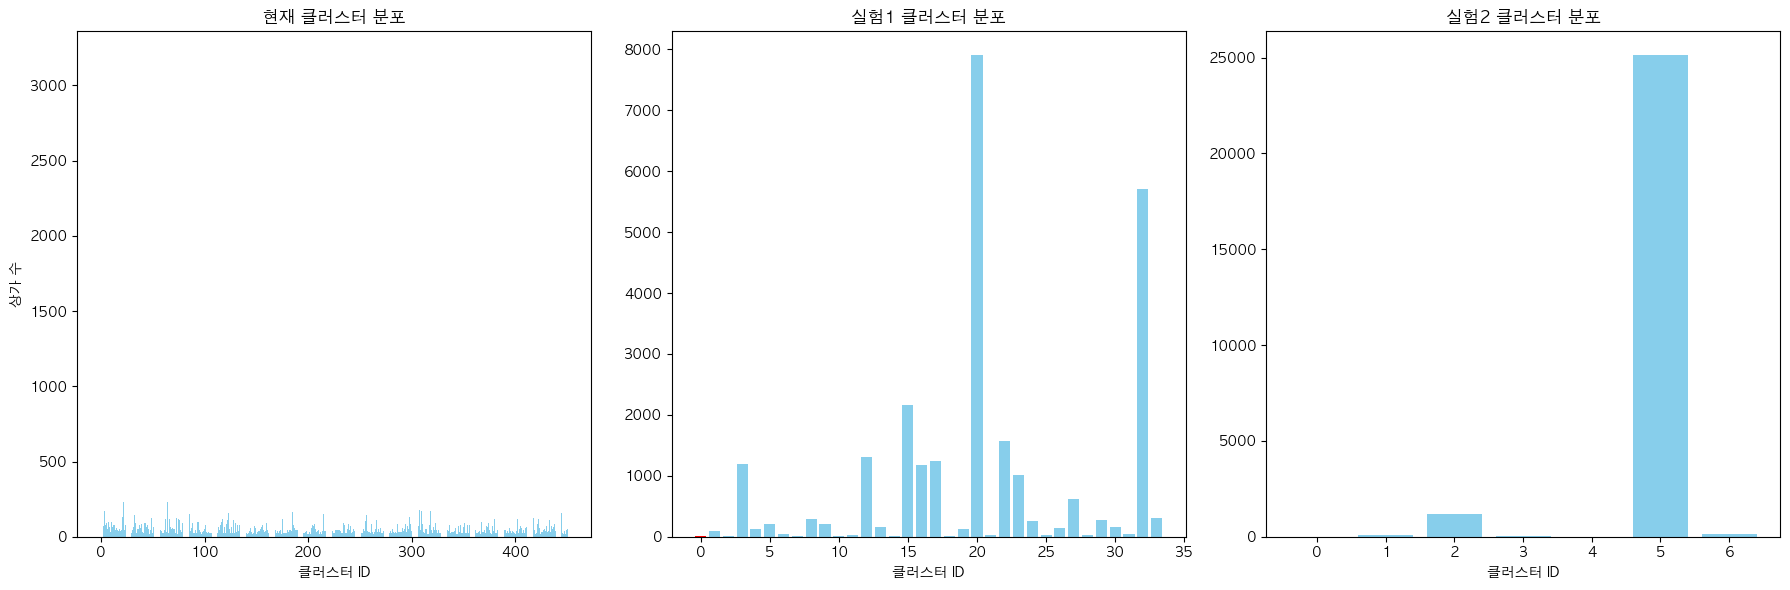

In [11]:
# 노이즈 줄이기 실험 결과 시각화
import matplotlib.pyplot as plt
import seaborn as sns

# 실험 결과 데이터 준비
experiment_names = ['현재', '실험1', '실험2']
noise_counts = [
    len(df[df['cluster'] == -1]),  # 현재
    noise_count_1,                 # 실험1
    noise_count_2                  # 실험2
]
cluster_counts = [
    len(set(df['cluster'])) - 1,   # 현재
    len(set(labels_1)) - (1 if -1 in labels_1 else 0),  # 실험1
    len(set(labels_2)) - (1 if -1 in labels_2 else 0)   # 실험2
]

# 1. 노이즈 수 비교 그래프
plt.figure(figsize=(12, 8))

# 서브플롯 1: 노이즈 수 비교
plt.subplot(2, 2, 1)
bars1 = plt.bar(experiment_names, noise_counts, color=['red', 'orange', 'green'])
plt.title('노이즈 수 비교', fontsize=14, fontweight='bold')
plt.ylabel('노이즈 수')
for bar, count in zip(bars1, noise_counts):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5, 
             f'{count}개', ha='center', va='bottom', fontweight='bold')

# 서브플롯 2: 노이즈 비율 비교
plt.subplot(2, 2, 2)
noise_ratios = [count/len(df)*100 for count in noise_counts]
bars2 = plt.bar(experiment_names, noise_ratios, color=['red', 'orange', 'green'])
plt.title('노이즈 비율 비교', fontsize=14, fontweight='bold')
plt.ylabel('노이즈 비율 (%)')
for bar, ratio in zip(bars2, noise_ratios):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
             f'{ratio:.1f}%', ha='center', va='bottom', fontweight='bold')

# 서브플롯 3: 클러스터 수 비교
plt.subplot(2, 2, 3)
bars3 = plt.bar(experiment_names, cluster_counts, color=['blue', 'lightblue', 'cyan'])
plt.title('클러스터 수 비교', fontsize=14, fontweight='bold')
plt.ylabel('클러스터 수')
for bar, count in zip(bars3, cluster_counts):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
             f'{count}개', ha='center', va='bottom', fontweight='bold')

# 서브플롯 4: 개선 효과
plt.subplot(2, 2, 4)
improvement = [(noise_counts[0] - count)/noise_counts[0]*100 for count in noise_counts]
bars4 = plt.bar(experiment_names, improvement, color=['gray', 'lightgreen', 'green'])
plt.title('노이즈 감소 효과', fontsize=14, fontweight='bold')
plt.ylabel('감소율 (%)')
for bar, imp in zip(bars4, improvement):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
             f'{imp:.1f}%', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# 2. 실험별 클러스터 분포 비교
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# 현재 클러스터 분포
current_clusters = df['cluster'].value_counts().sort_index()
axes[0].bar(range(len(current_clusters)), current_clusters.values, 
            color=['red' if x == -1 else 'skyblue' for x in current_clusters.index])
axes[0].set_title('현재 클러스터 분포', fontweight='bold')
axes[0].set_xlabel('클러스터 ID')
axes[0].set_ylabel('상가 수')

# 실험1 클러스터 분포
exp1_clusters = pd.Series(labels_1).value_counts().sort_index()
axes[1].bar(range(len(exp1_clusters)), exp1_clusters.values,
            color=['red' if x == -1 else 'skyblue' for x in exp1_clusters.index])
axes[1].set_title('실험1 클러스터 분포', fontweight='bold')
axes[1].set_xlabel('클러스터 ID')

# 실험2 클러스터 분포
exp2_clusters = pd.Series(labels_2).value_counts().sort_index()
axes[2].bar(range(len(exp2_clusters)), exp2_clusters.values,
            color=['red' if x == -1 else 'skyblue' for x in exp2_clusters.index])
axes[2].set_title('실험2 클러스터 분포', fontweight='bold')
axes[2].set_xlabel('클러스터 ID')

plt.tight_layout()
plt.show()

In [12]:
selected_result = '실험1'  # '현재', '실험1', '실험2' 중 선택

if selected_result == '실험1':
    df['cluster'] = labels_1
    clusterer = clusterer_1
elif selected_result == '실험2':
    df['cluster'] = labels_2
    clusterer = clusterer_2
# '현재'는 이미 반영되어 있음

print(f"\n[{selected_result}] 결과로 데이터프레임이 업데이트되었습니다.")
print(df['cluster'].value_counts().sort_index())


[실험1] 결과로 데이터프레임이 업데이트되었습니다.
cluster
-1       16
 0       99
 1       20
 2     1200
 3      127
 4      210
 5       45
 6       11
 7      289
 8      217
 9       15
 10      35
 11    1305
 12     165
 13      15
 14    2167
 15    1173
 16    1236
 17      13
 18     119
 19    7902
 20      22
 21    1571
 22    1021
 23     259
 24      31
 25     141
 26     619
 27      26
 28     277
 29     160
 30      39
 31    5709
 32     311
Name: count, dtype: int64


In [13]:
print(f"\n=== {selected_result} 클러스터별 주요 업종/지역 분석 ===")
for cluster_id in sorted(df['cluster'].unique()):
    if cluster_id != -1:  # 노이즈 제외
        cluster_data = df[df['cluster'] == cluster_id]
        print(f"\n클러스터 {cluster_id} ({len(cluster_data)}개):")
        # 주요 업종 대분류
        major_business = cluster_data['상권업종대분류명'].value_counts().head(3)
        print(f"  주요 업종: {dict(major_business)}")
        # 주요 지역
        major_area = cluster_data['행정동명'].value_counts().head(3)
        print(f"  주요 지역: {dict(major_area)}")


=== 실험1 클러스터별 주요 업종/지역 분석 ===

클러스터 0 (99개):
  주요 업종: {'예술·스포츠': 99}
  주요 지역: {'장유3동': 27, '북부동': 17, '내외동': 13}

클러스터 1 (20개):
  주요 업종: {'수리·개인': 20}
  주요 지역: {'부원동': 3, '북부동': 3, '활천동': 2}

클러스터 2 (1200개):
  주요 업종: {'음식': 1200}
  주요 지역: {'장유3동': 171, '북부동': 134, '내외동': 133}

클러스터 3 (127개):
  주요 업종: {'과학·기술': 127}
  주요 지역: {'장유2동': 19, '내외동': 19, '북부동': 17}

클러스터 4 (210개):
  주요 업종: {'수리·개인': 210}
  주요 지역: {'북부동': 34, '내외동': 33, '진영읍': 26}

클러스터 5 (45개):
  주요 업종: {'과학·기술': 45}
  주요 지역: {'북부동': 7, '내외동': 6, '장유3동': 6}

클러스터 6 (11개):
  주요 업종: {'숙박': 11}
  주요 지역: {'활천동': 3, '장유2동': 2, '부원동': 2}

클러스터 7 (289개):
  주요 업종: {'숙박': 289}
  주요 지역: {'부원동': 57, '장유2동': 51, '활천동': 47}

클러스터 8 (217개):
  주요 업종: {'보건의료': 217}
  주요 지역: {'내외동': 52, '장유3동': 34, '부원동': 25}

클러스터 9 (15개):
  주요 업종: {'보건의료': 15}
  주요 지역: {'장유3동': 5, '내외동': 3, '삼안동': 2}

클러스터 10 (35개):
  주요 업종: {'수리·개인': 35}
  주요 지역: {'진영읍': 6, '활천동': 5, '삼안동': 4}

클러스터 11 (1305개):
  주요 업종: {'과학·기술': 1305}
  주요 지역: {'부원동': 294, '내외동': 162, '장

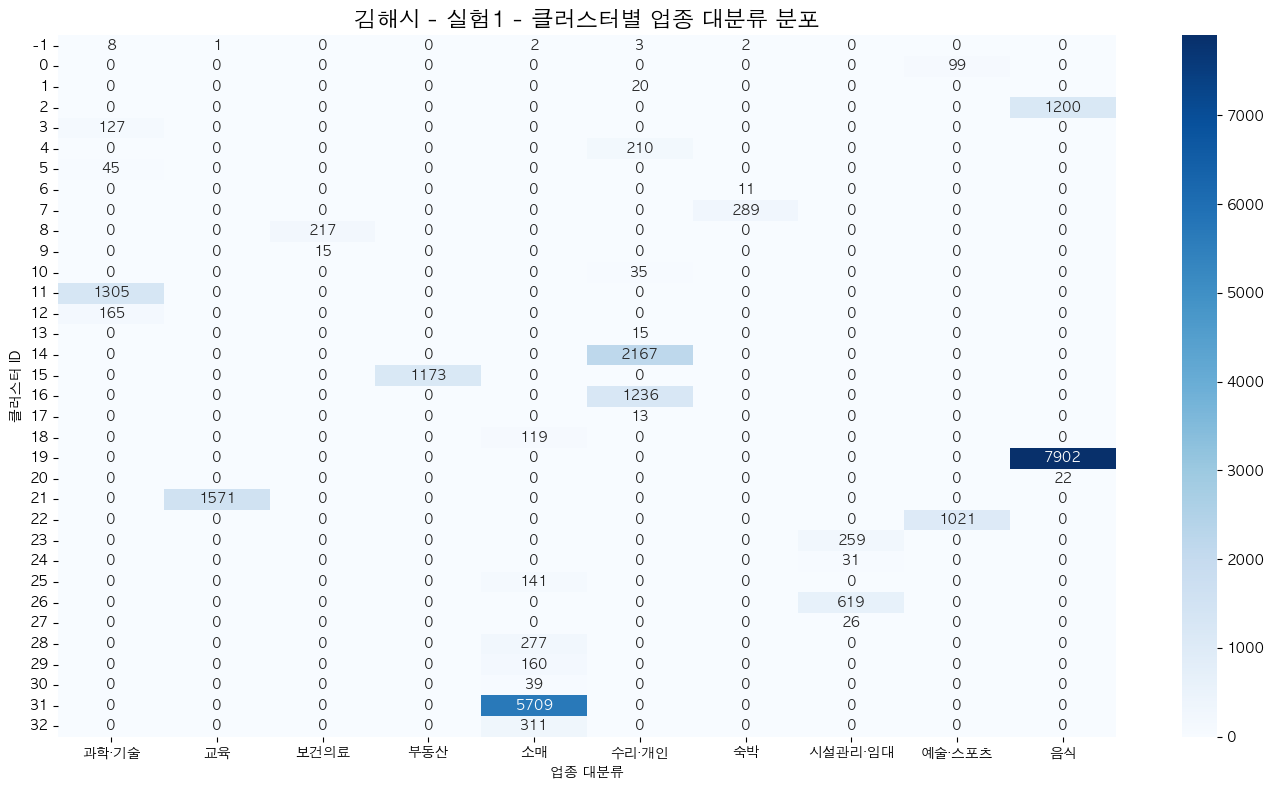

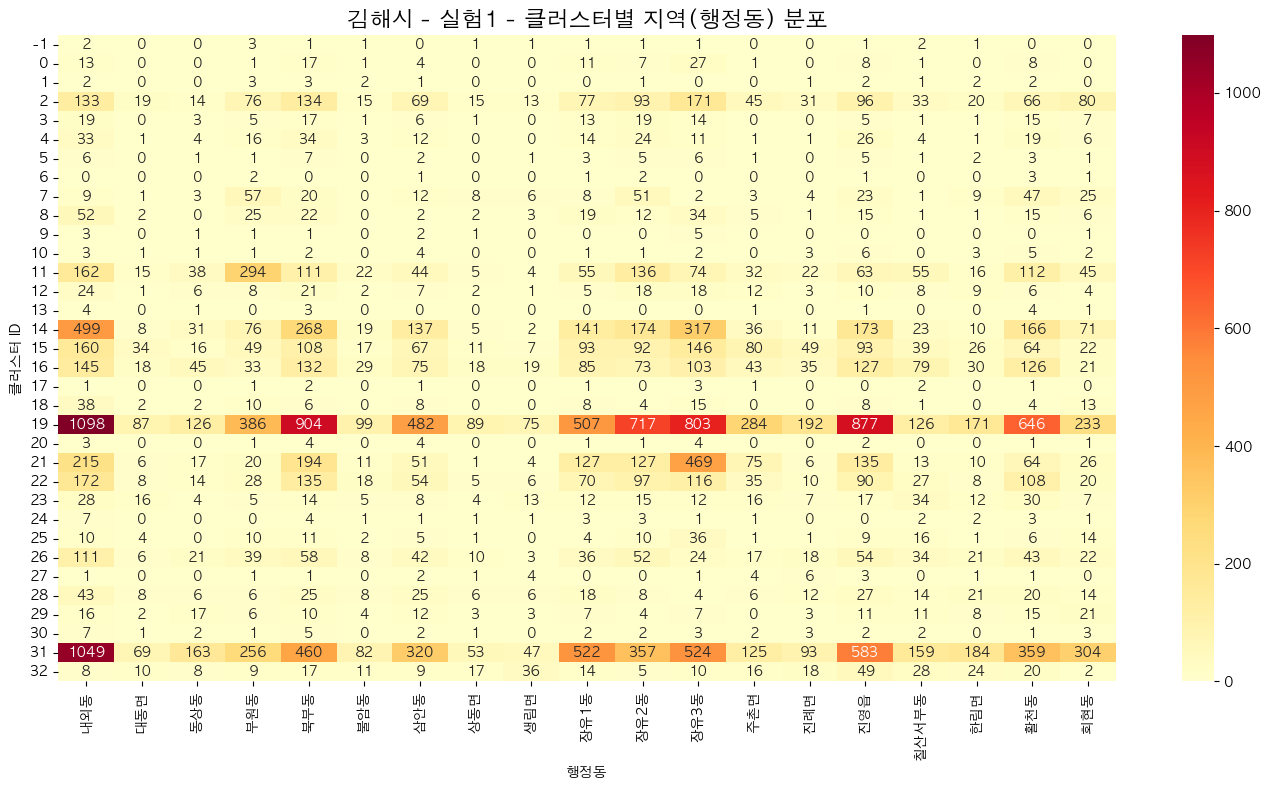

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# 클러스터별 업종 분포 히트맵
plt.figure(figsize=(14, 8))
cluster_business_pivot = pd.crosstab(df['cluster'], df['상권업종대분류명'])
sns.heatmap(cluster_business_pivot, annot=True, fmt='d', cmap='Blues')
plt.title(f'{cityname} - {selected_result} - 클러스터별 업종 대분류 분포', fontsize=16, fontweight='bold')
plt.xlabel('업종 대분류')
plt.ylabel('클러스터 ID')
plt.tight_layout()
plt.show()

# 클러스터별 지역 분포 히트맵
plt.figure(figsize=(14, 8))
cluster_area_pivot = pd.crosstab(df['cluster'], df['행정동명'])
sns.heatmap(cluster_area_pivot, annot=True, fmt='d', cmap='YlOrRd')
plt.title(f'{cityname} - {selected_result} - 클러스터별 지역(행정동) 분포', fontsize=16, fontweight='bold')
plt.xlabel('행정동')
plt.ylabel('클러스터 ID')
plt.tight_layout()
plt.show()

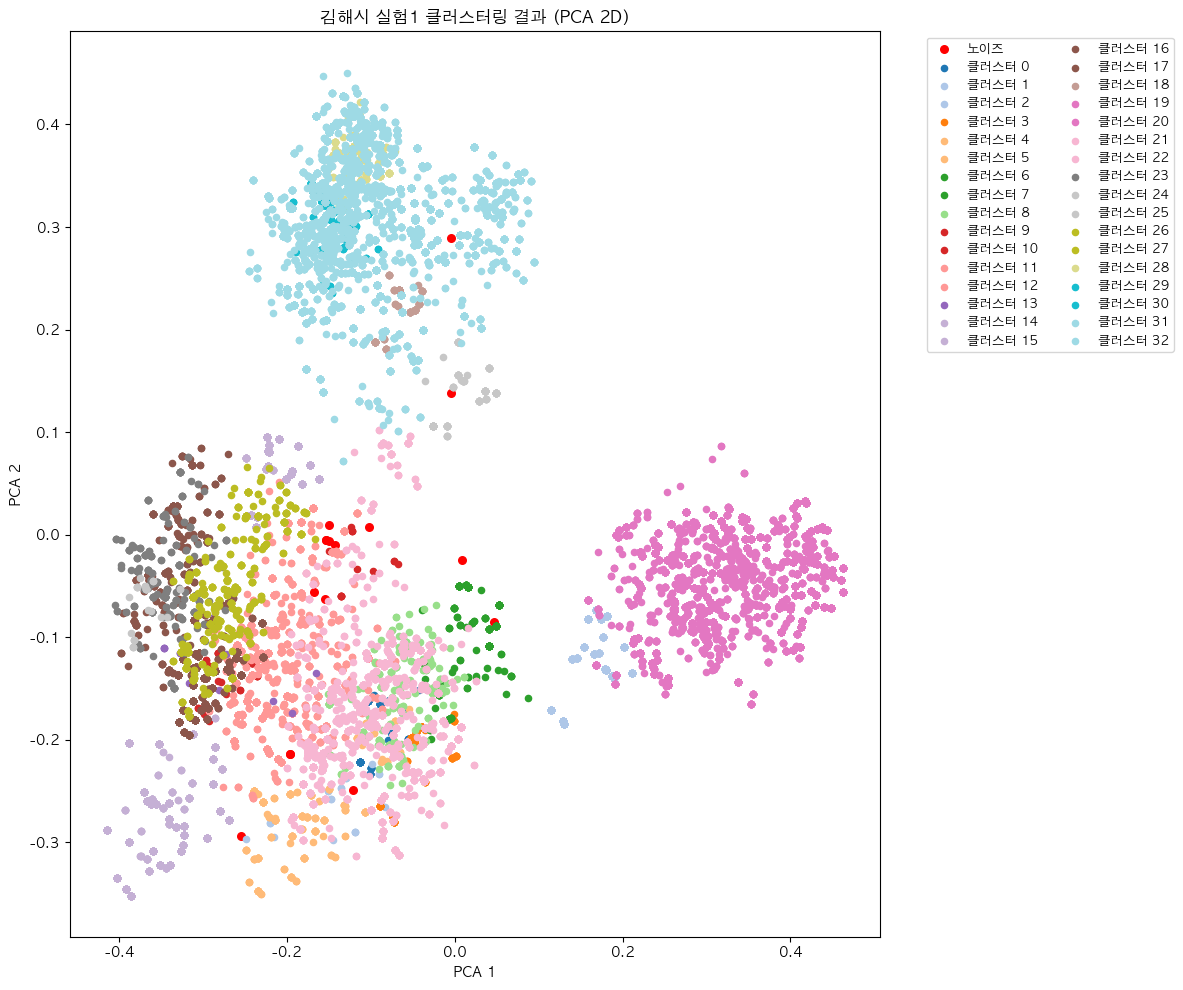

In [15]:
pca = PCA(n_components=2)
emb_2d = pca.fit_transform(emb)

plt.figure(figsize=(12, 10))
unique_clusters = np.unique(df['cluster'])
colors = plt.cm.tab20(np.linspace(0, 1, len(unique_clusters)))

for i, cluster_id in enumerate(unique_clusters):
    mask = df['cluster'] == cluster_id
    if cluster_id == -1:
        plt.scatter(emb_2d[mask, 0], emb_2d[mask, 1], c='red', s=30, label='노이즈')
    else:
        plt.scatter(emb_2d[mask, 0], emb_2d[mask, 1], color=colors[i], s=20, label=f'클러스터 {cluster_id}')

plt.title(f'{cityname} 실험1 클러스터링 결과 (PCA 2D)')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9, ncol=2)
plt.tight_layout()
plt.show()

In [16]:
# 클러스터링 결과가 포함된 원본 데이터프레임을 찾기
print("사용 가능한 변수들:")

# 현재 네임스페이스에서 데이터프레임 변수들을 찾기
import pandas as pd
import numpy as np

# 현재 변수들을 확인
current_vars = [var for var in dir() if not var.startswith('_')]
print("현재 변수들:", current_vars)

# 클러스터링 결과가 포함된 데이터프레임 찾기
df_cluster = None
for var_name in current_vars:
    try:
        var = eval(var_name)
        if isinstance(var, pd.DataFrame) and 'cluster' in var.columns:
            print(f"클러스터링 결과 발견: {var_name}")
            df_cluster = var
            break
    except:
        continue

# 클러스터별 의미있는 이름 생성
def get_cluster_name(cluster_id, df_cluster):
    """클러스터 ID를 기반으로 의미있는 이름을 생성"""
    if cluster_id == -1:
        return '노이즈'
    
    cluster_data = df_cluster[df_cluster['cluster'] == cluster_id]
    
    # 주요 업종 대분류
    major_business = cluster_data['상권업종대분류명'].value_counts().index[0]
    
    # 주요 업종 중분류 (상위 2개)
    major_sub_business = cluster_data['상권업종중분류명'].value_counts().head(2)
    
    # 클러스터 크기
    cluster_size = len(cluster_data)
    
    # 이름 생성 규칙
    if major_business == '소매':
        if '식료품' in major_sub_business.index[0]:
            return f'식료품소매 ({cluster_size}개)'
        elif '의류' in major_sub_business.index[0]:
            return f'의류소매 ({cluster_size}개)'
        else:
            return f'소매업 ({cluster_size}개)'
    elif major_business == '음식':
        if '한식' in major_sub_business.index[0]:
            return f'한식점 ({cluster_size}개)'
        elif '카페' in major_sub_business.index[0]:
            return f'카페 ({cluster_size}개)'
        else:
            return f'음식점 ({cluster_size}개)'
    elif major_business == '수리·개인':
        if '이용·미용' in major_sub_business.index[0]:
            return f'미용업 ({cluster_size}개)'
        else:
            return f'수리서비스 ({cluster_size}개)'
    elif major_business == '부동산':
        return f'부동산 ({cluster_size}개)'
    elif major_business == '교육':
        return f'교육업 ({cluster_size}개)'
    elif major_business == '보건의료':
        return f'의료업 ({cluster_size}개)'
    elif major_business == '숙박':
        return f'숙박업 ({cluster_size}개)'
    elif major_business == '과학·기술':
        return f'기술서비스 ({cluster_size}개)'
    elif major_business == '시설관리·임대':
        return f'시설관리 ({cluster_size}개)'
    elif major_business == '예술·스포츠':
        return f'문화스포츠 ({cluster_size}개)'
    else:
        return f'{major_business} ({cluster_size}개)'

# 클러스터링 결과가 포함된 데이터프레임을 찾았는지 확인
if df_cluster is not None:
    print(f"\n=== {cityname} 클러스터별 상세 정보 ===")
    unique_clusters = np.unique(df_cluster['cluster'])

    for cluster_id in sorted(unique_clusters):
        if cluster_id != -1:
            cluster_data = df_cluster[df_cluster['cluster'] == cluster_id]
            cluster_name = get_cluster_name(cluster_id, df_cluster)
            
            print(f"\n{cluster_name}:")
            
            # 주요 업종
            major_business = cluster_data['상권업종대분류명'].value_counts().head(3)
            print(f"  주요 업종: {dict(major_business)}")
            
            # 주요 중분류
            major_sub = cluster_data['상권업종중분류명'].value_counts().head(3)
            print(f"  주요 중분류: {dict(major_sub)}")
            
            # 주요 지역
            major_area = cluster_data['행정동명'].value_counts().head(3)
            print(f"  주요 지역: {dict(major_area)}")
            
            # 샘플 상가
            sample_business = cluster_data['상권업종소분류명'].value_counts().head(3)
            print(f"  대표 업종: {dict(sample_business)}")
        else:
            print(f"\n노이즈 ({len(df_cluster[df_cluster['cluster'] == -1])}개):")
            noise_data = df_cluster[df_cluster['cluster'] == -1]
            print(f"  주요 업종: {dict(noise_data['상권업종대분류명'].value_counts().head(3))}")

    # 클러스터 이름 매핑 딕셔너리 생성
    cluster_name_mapping = {}
    for cluster_id in unique_clusters:
        cluster_name_mapping[cluster_id] = get_cluster_name(cluster_id, df_cluster)

    print(f"\n=== 클러스터 이름 매핑 ===")
    for cluster_id, name in cluster_name_mapping.items():
        print(f"클러스터 {cluster_id} → {name}")
        
    # PCA 시각화도 업데이트
    pca = PCA(n_components=2)
    emb_2d = pca.fit_transform(emb)

    plt.figure(figsize=(14, 10))
    colors = plt.cm.tab20(np.linspace(0, 1, len(unique_clusters)))

    for i, cluster_id in enumerate(unique_clusters):
        mask = df_cluster['cluster'] == cluster_id
        cluster_name = get_cluster_name(cluster_id, df_cluster)
        
        if cluster_id == -1:
            plt.scatter(emb_2d[mask, 0], emb_2d[mask, 1], c='red', s=30, label=cluster_name)
        else:
            plt.scatter(emb_2d[mask, 0], emb_2d[mask, 1], color=colors[i], s=20, label=cluster_name)

    plt.title(f'{cityname} 실험1 클러스터링 결과 (PCA 2D)', fontsize=14, fontweight='bold')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10, ncol=1)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
else:
    print("클러스터링 결과가 포함된 데이터프레임을 찾을 수 없습니다.")
    print("다음 중 하나를 시도해보세요:")
    print("1. 클러스터링 코드를 다시 실행")
    print("2. 클러스터링 결과가 저장된 변수명을 직접 지정")
    print("3. 원본 데이터를 다시 로드하여 클러스터링 수행")

사용 가능한 변수들:
현재 변수들: ['BATCH', 'In', 'MODEL_ID', 'Out', 'PCA', 'SentenceTransformer', 'axes', 'bar', 'bars1', 'bars2', 'bars3', 'bars4', 'batch', 'city_counts', 'cityname', 'clean', 'cluster_13_data', 'cluster_area_pivot', 'cluster_business_pivot', 'cluster_counts', 'cluster_data', 'cluster_id', 'clusterer', 'clusterer_1', 'clusterer_2', 'colors', 'count', 'current_clusters', 'd', 'df', 'emb', 'emb_2d', 'emb_list', 'embedder', 'embs', 'exit', 'exp1_clusters', 'exp2_clusters', 'experiment_names', 'faiss', 'fig', 'find_similar', 'find_similar_with_details', 'get_ipython', 'hdbscan', 'i', 'idx', 'imp', 'improvement', 'index', 'joblib', 'labels_1', 'labels_2', 'major_area', 'major_business', 'mask', 'min_cluster', 'min_samples', 'n', 'noise_count_1', 'noise_count_2', 'noise_counts', 'noise_mask', 'noise_ratios', 'np', 'open', 'pca', 'pd', 'plt', 'quit', 'ratio', 're', 'row', 'scatter', 'selected_columns', 'selected_result', 'sns', 'tqdm', 'unique_clusters']
클러스터링 결과 발견: cluster_13_data

===

IndexError: boolean index did not match indexed array along dimension 0; dimension is 26565 but corresponding boolean dimension is 3200

<Figure size 1400x1000 with 0 Axes>

_____

데이터 형태: (15, 196)
컬럼명: ['행정구역', '2020년_거주자_총인구수', '2020년_거주자_연령구간인구수', '2020년_거주자_0~9세', '2020년_거주자_10~19세', '2020년_거주자_20~29세', '2020년_거주자_30~39세', '2020년_거주자_40~49세', '2020년_거주자_50~59세', '2020년_거주자_60~69세']


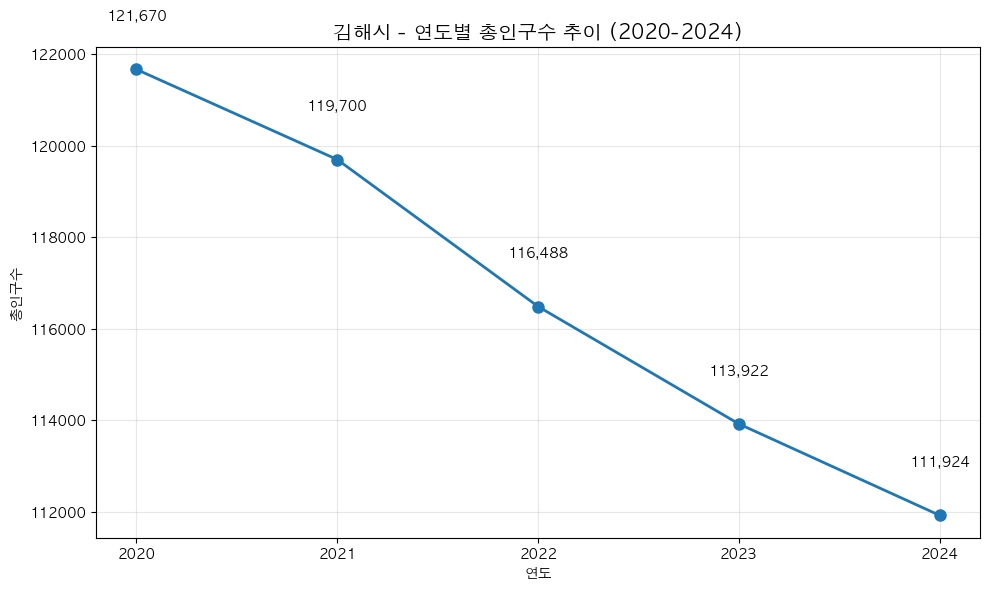

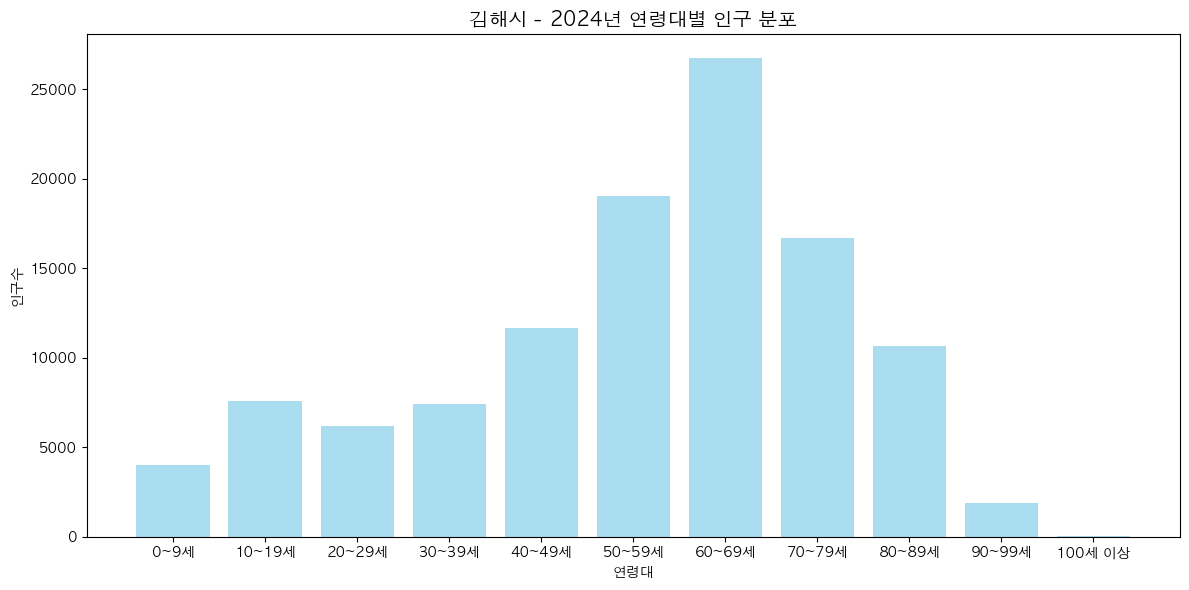

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 연간 인구 데이터 불러오기 (CP949 인코딩 사용)
df = pd.read_csv('./data/202012_202412_연령별인구현황_연간.csv', encoding='cp949')

# 데이터 구조 확인
print("데이터 형태:", df.shape)
print("컬럼명:", df.columns.tolist()[:10])  # 처음 10개만 출력

# 연도별 총인구수 추출 (2020-2024년)
years = ['2020', '2021', '2022', '2023', '2024']
total_population = []

for year in years:
    col_name = f'{year}년_거주자_총인구수'
    if col_name in df.columns:
        # 쉼표 제거하고 숫자로 변환
        population = df[col_name].astype(str).str.replace(',', '').astype(float).sum()
        total_population.append(population)

# 연도별 총인구수 시각화
plt.figure(figsize=(10, 6))
plt.plot(years, total_population, marker='o', linewidth=2, markersize=8)
plt.title(f'{cityname} - 연도별 총인구수 추이 (2020-2024)', fontsize=14, fontweight='bold')
plt.xlabel('연도')
plt.ylabel('총인구수')
plt.grid(True, alpha=0.3)

# 값 표시
for i, (year, pop) in enumerate(zip(years, total_population)):
    plt.text(i, pop + 1000, f'{pop:,.0f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# 연령대별 인구 분포 (2024년 기준)
age_columns = [col for col in df.columns if '2024년_거주자_' in col and '총인구수' not in col and '연령구간인구수' not in col]
age_data = []

for col in age_columns:
    age_group = col.replace('2024년_거주자_', '').replace('세', '세')
    # 문자열로 변환 후 쉼표 제거하고 숫자로 변환
    population = df[col].astype(str).str.replace(',', '').astype(float).sum()
    age_data.append((age_group, population))

# 연령대별 인구 분포 시각화
age_groups, populations = zip(*age_data)

plt.figure(figsize=(12, 6))
bars = plt.bar(age_groups, populations, color='skyblue', alpha=0.7)
plt.title(f'{cityname} - 2024년 연령대별 인구 분포', fontsize=14, fontweight='bold')
plt.xlabel('연령대')
plt.ylabel('인구수')
plt.tight_layout()
plt.show()

-----

여기부터는 .py 에서 진행

7. 새 글 추가 → 실시간 검색 + 인덱스 갱신

In [15]:
def add_idea(new_row: dict, search_k: int = 5):
    """
    새 아이디어 1건을
      1) 전처리·임베딩
      2) FAISS 검색 → 유사도 top-k 반환
      3) 인덱스·데이터프레임·임베딩 배열 업데이트
    """
    global emb, df, index

    # 1) 전처리 + 임베딩
    cleaned = clean(new_row["title"] + " " + new_row["body"])
    vec     = embedder.encode([cleaned], normalize_embeddings=True).astype("float32")

    # 2) 유사도 검색
    D, I = index.search(vec, search_k)
    similar = [(int(idx), float(score)) for idx, score in zip(I[0], D[0])]

    # 3-A) 인덱스·임베딩 배열 업데이트
    index.add(vec)                          # FAISS에 즉시 반영
    emb = np.vstack([emb, vec])             # ndarray 확장

    # 3-B) 데이터프레임 업데이트
    #     ★ 여기서 오류가 났던 부분 → 중괄호 개수 수정
    df = pd.concat(
        [df, pd.DataFrame([ new_row | {"clean": cleaned} ])],
        ignore_index=True
    )

    return similar

Note: HDBSCAN은 증분 학습이 불가하므로
cron or Airflow로 5분마다 전체 재빌드 (clusterer.fit(emb))를 돌리면 됩니다.

8. 프론트 연동 초간단 API

In [ ]:
import sys
!{str(sys.executable)} -m pip install fastapi

In [17]:
from fastapi import FastAPI
app = FastAPI()

@app.post("/submit")
def submit(idea: dict):
    sim = add_idea(idea)
    # 코사인 0.7↑ + 같은 cluster 아이템만 추천
    recs = [idx for idx, sc in sim if sc > 0.7 and
            df.loc[idx, "cluster"] == df.iloc[-1]["cluster"]]
    return {"similar_ids": recs}

In [ ]:
import sys
!{str(sys.executable)} -m pip install fastapi uvicorn pydantic[dotenv] requests